In [1]:
import torch
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn as nn
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
torch.cuda.is_available()

True

In [3]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test,y_pred,labels=None,lenth=20,ratio=False,cmap="Blues",annot=True,width=12,fmt="g"):
    if labels == None:
        labels = pd.Series(labels for labels in y_test.squeeze()).unique()
    conf_mat = pd.DataFrame(confusion_matrix(y_test.squeeze(), y_pred.squeeze(), labels=labels))
    if ratio == True:
        conf_mat = conf_mat.divide(conf_mat.sum(axis=1), axis=0)
    fig, ax = plt.subplots(figsize=(lenth, width))
    sns.heatmap(conf_mat,cmap=cmap,annot=annot,xticklabels=labels,yticklabels=labels,fmt=fmt)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

In [4]:
f = open('idx2word_big.pkl','rb')
idx2word= pickle.load(f)
f.close()
f = open('df_big.pkl','rb')
word_df= pickle.load(f)
f.close()
f = open('embedding_big.pkl','rb')
word_embedding= pickle.load(f)
f.close()

In [5]:
EOS_NUM = 0
UNK_NUM = 1
PADDLING_NUM = 2

In [6]:
word_df['text'].apply(len).describe()

count    56821.000000
mean         9.087344
std          2.868494
min          0.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         48.000000
Name: text, dtype: float64

In [7]:
word_df['text'].apply(len).describe()

count    56821.000000
mean         9.087344
std          2.868494
min          0.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         48.000000
Name: text, dtype: float64

In [8]:
len(word_embedding)

355990

In [9]:
def getWordEmbedding(data):
    seq_embed = []
    _ = 0
    for word in data:
        seq_embed.append(word_embedding[word])
        _ += 1
        if _ == 9:
            break
    if _ <= 9:
        for i in range(9 - _):
            seq_embed.append(np.zeros(300))
    seq_embed = np.array(seq_embed)
    return seq_embed

In [10]:
# def getWordEmbedding(data):
#     seq_embed = []
#     _ = 0
#     for word in data:
#         seq_embed.append(word)
#         _ += 1
#         if _ == 9:
#             break
#     if _ <= 9:
#         for i in range(9 - _):
#             seq_embed.append()
#     seq_embed = np.array(seq_embed)
#     return seq_embed

In [11]:
word_df['text'] = word_df['text'].apply(getWordEmbedding)

In [12]:
train_df = word_df[['text','class']]
train_df['class'] = train_df['class'].apply(np.float32)

C:\Users\Javon\AppData\Local\Temp/ipykernel_15260/72822735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class'] = train_df['class'].apply(np.float32)


In [13]:
train_df['text'][0]

array([[ 0.77897102, -0.24356601, -0.26709101, ..., -0.371645  ,
         1.04136801,  0.18475001],
       [-0.005251  , -0.203603  , -0.764615  , ..., -0.31193799,
         0.56219399, -0.002608  ],
       [ 1.29011798, -0.39268801, -0.42361701, ...,  0.41950399,
         0.20449001,  0.64937598],
       ...,
       [ 0.079874  , -0.130665  ,  0.27537099, ...,  0.214256  ,
         0.33445001,  0.84352601],
       [-0.29280099,  0.449341  ,  0.14328299, ...,  0.15883499,
         0.67825699, -0.58762503],
       [ 0.38094899,  0.39534199, -0.105029  , ...,  0.35614899,
        -0.122519  ,  0.90290499]])

In [14]:
X_train,X_test,y_train,y_test = train_test_split(
    train_df['text'].values,
    train_df['class'].values,
    test_size=0.2,
    stratify=train_df['class'],
    random_state=42,
)

In [15]:
class seqDataset(torch.utils.data.Dataset):
    def __init__(self,data,label,transformer = None):
        super(seqDataset,self).__init__()
        self.data = data
        self.label = label
        self.transformer = transformer
    
    def __getitem__(self,idx):
        if self.transformer:
            return transformer(self.data[idx]),self.label[idx]
        return self.data[idx],self.label[idx]
    
    def __len__(self):
        return len(self.data)

In [16]:
X_train = [np.array(i) for i in X_train]
X_test = [np.array(i) for i in X_test]

In [17]:
X_train[0]

array([[ 0.533471, -0.738836, -0.745665, ...,  0.127822, -0.522074,
         0.193523],
       [-0.030646, -0.128678,  0.033818, ...,  0.174529, -0.073322,
         0.034218],
       [-0.365248, -0.336133, -0.045593, ...,  0.648002,  0.211448,
         0.375935],
       ...,
       [-0.445826, -0.097827,  0.230186, ...,  0.051419, -0.328975,
         0.01057 ],
       [-0.10139 , -0.143253, -0.035549, ...,  0.140243, -0.162254,
         0.017669],
       [-0.060803,  0.300508,  0.512175, ..., -0.168457, -0.568124,
         0.533321]], dtype=float32)

In [18]:
train_dataset = seqDataset(X_train,y_train)
test_dataset = seqDataset(X_test,y_test)

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=500)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=500)

In [20]:
for i,(x,y) in enumerate(train_loader):
    print(x.shape)
    break

torch.Size([500, 9, 300])


In [21]:
def train(model,EPOCH=150,learning_rate=0.05):
    model = model
    opt = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    EPOCH = EPOCH
    itr = 0
    model.cuda()
    for epoch in range(EPOCH):
        for i,(x,y) in enumerate(train_loader):
            batch_X = torch.FloatTensor(np.float32(x)).cuda()
            batch_Y = torch.LongTensor(np.int64(y)).cuda()
            output = model(batch_X)
            opt.zero_grad()
            loss = loss_fn(output,batch_Y)
            loss.backward()
            opt.step()
            if (i+1) % 20 == 0:
                itr += 20
                acc = (batch_Y.detach().cpu().numpy() == output.detach().cpu().argmax(axis=1).numpy()).mean()
                print('epoch\t:{}\titr:{}\tloss:{}\tacc:{}\n'.format(epoch,itr,loss,acc))
                # print(output.detach().cpu())
    return model

def test(model):
    accs = []
    y_pred = []
    y_true = []
    for i,(x,y) in enumerate(test_loader):
        batch_X = torch.FloatTensor(np.float32(x)).cuda()
        batch_Y = torch.LongTensor(np.int64(y)).cuda()
        output = model(batch_X)
        acc = (batch_Y.detach().cpu().numpy() == output.detach().cpu().argmax(axis=1).numpy()).mean()
        accs.append(acc)
        y_pred.extend(output.detach().cpu().argmax(axis=1).numpy())
        y_true.extend(batch_Y.detach().cpu().numpy()) 
    print(np.array(accs).mean())
    return y_pred,y_true

In [22]:
class SimpleRNN(nn.Module):
    def __init__(self,seq_len=9,embedding_size=300,h1_size=128,num_embeddings = len(idx2word)):
        super(SimpleRNN,self).__init__()
        self.embedding_size = embedding_size
        self.h1_size = h1_size
        self.seq_len = seq_len
        self.num_embeddings = num_embeddings

        self.embed = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)

        self.layer1 = nn.Sequential(
            nn.RNN(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=4,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.seq_len*self.h1_size,self.h1_size),
            nn.Sigmoid(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.embed(x)
        out,hid = self.layer1(x)
        out = self.output(out)
        return out

In [23]:
class SimpleLSTM(nn.Module):
    def __init__(self,seq_len=9,embedding_size=300,h1_size=128,num_embeddings = len(idx2word)):
        super(SimpleLSTM,self).__init__()
        self.embedding_size = embedding_size
        self.h1_size = h1_size
        self.seq_len = seq_len
        self.num_embeddings = num_embeddings

        self.embed = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)

        self.layer1 = nn.Sequential(
            nn.LSTM(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=4,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.embed(x)
        out,(hn, cn) = self.layer1(x)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [24]:
class TransformerLSTM(nn.Module):
    def __init__(self,seq_len=9,embedding_size=300,num_embeddings = len(idx2word),h1_size = 100):
        super(TransformerLSTM,self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_size = embedding_size
        self.seq_len = seq_len
        self.h1_size = h1_size
        self.emb = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.layer1 = nn.Sequential(
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
        )
        self.layer2 = nn.Sequential(
            nn.LSTM(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=2,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.emb(x)
        out = self.layer1(x)
        out,hid = self.layer2(out)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [32]:
class TransformerRNN(nn.Module):
    def __init__(self,seq_len=9,embedding_size=300,num_embeddings = len(idx2word),h1_size = 100):
        super(TransformerRNN,self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_size = embedding_size
        self.seq_len = seq_len
        self.h1_size = h1_size
        self.emb = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.layer1 = nn.Sequential(
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
        )
        self.layer2 = nn.Sequential(
            nn.RNN(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=2,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.emb(x)
        out = self.layer1(x)
        out,hid = self.layer2(out)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [25]:
class TransformerCNN(nn.Module):
    def __init__(self,seq_len=9,embedding_size=300,num_embeddings = len(idx2word),h1_size = 100):
        super(TransformerCNN,self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_size = embedding_size
        self.seq_len = seq_len
        self.h1_size = h1_size
        self.emb = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.layer1 = nn.Sequential(
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels = 300,out_channels = 200,kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(200),
        )

        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels = 200,out_channels = 100,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(100),
        )

        self.layer4 = nn.Sequential(
            nn.Conv1d(in_channels = 100,out_channels = 100,kernel_size=4),
            nn.ReLU(),
            nn.BatchNorm1d(100),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.emb(x)
        out = self.layer1(x)
        out = self.layer2(out.transpose(2,1))
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.output(out)
        return out

In [26]:
class TransformerEncoder(nn.Module):
    def __init__(self,seq_len=9,embedding_size=300,num_embeddings = len(idx2word)):
        super(TransformerEncoder,self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_size = embedding_size
        self.seq_len = seq_len
        self.emb = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.layer1 = nn.Sequential(
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=10, batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.embedding_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.emb(x)
        out = self.layer1(x)
        
        out = self.output(out)
        return out

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self,embedding_size=300,num_embeddings = len(idx2word)):
        super(SimpleCNN,self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_size = embedding_size
        # self.embed = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels = 300,out_channels = 300,kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(300),
        )
        #[batch_size = 500,channels=128,seq_len - k_s + 1 = 8]
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels = 300,out_channels = 200,kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(200),
        )
        #[batch_size = 500,embedding_size = 128,seq_len - k_s + 1 = 7]
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels = 200,out_channels = 100,kernel_size=3,stride = 2),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            # nn.MaxPool1d(6),
        )
        #[batch_size = 500,embedding_size = 256,(seq_len - k_s)/2+ 1 = 3]
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels = 100,out_channels = 100,kernel_size = 3),
            nn.ReLU(),
            nn.BatchNorm1d(100),
        )
        #[batch_size = 500,embedding_size = 256,seq_len - k_s + 1 = 1]

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100,10),
            nn.Softmax()
        )
    def forward(self,x):
        # out = self.embed(x).transpose(2,1)
        out = self.conv1(x.transpose(2,1))
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.output(out)
        return out

In [ ]:
model = train(TransformerEncoder(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch	:0	itr:20	loss:2.235780954360962	acc:0.344

epoch	:0	itr:40	loss:2.049870491027832	acc:0.5

epoch	:0	itr:60	loss:1.9872252941131592	acc:0.524

epoch	:0	itr:80	loss:1.9046289920806885	acc:0.616

epoch	:1	itr:100	loss:1.8605295419692993	acc:0.634

epoch	:1	itr:120	loss:1.8484500646591187	acc:0.658

epoch	:1	itr:140	loss:1.8199316263198853	acc:0.694

epoch	:1	itr:160	loss:1.7845313549041748	acc:0.718

epoch	:2	itr:180	loss:1.7701247930526733	acc:0.712

epoch	:2	itr:200	loss:1.7469154596328735	acc:0.734

epoch	:2	itr:220	loss:1.7523729801177979	acc:0.738

epoch	:2	itr:240	loss:1.7248544692993164	acc:0.762

epoch	:3	itr:260	loss:1.7362457513809204	acc:0.742

epoch	:3	itr:280	loss:1.7122647762298584	acc:0.772

epoch	:3	itr:300	loss:1.7182410955429077	acc:0.774

epoch	:3	itr:320	loss:1.6981087923049927	acc:0.782

epoch	:4	itr:340	loss:1.7122787237167358	acc:0.76

epoch	:4	itr:360	loss:1.6886156797409058	acc:0.792

epoch	:4	itr:380	loss:1.7012808322906494	acc:0.778

epoch	:4	itr:400	loss

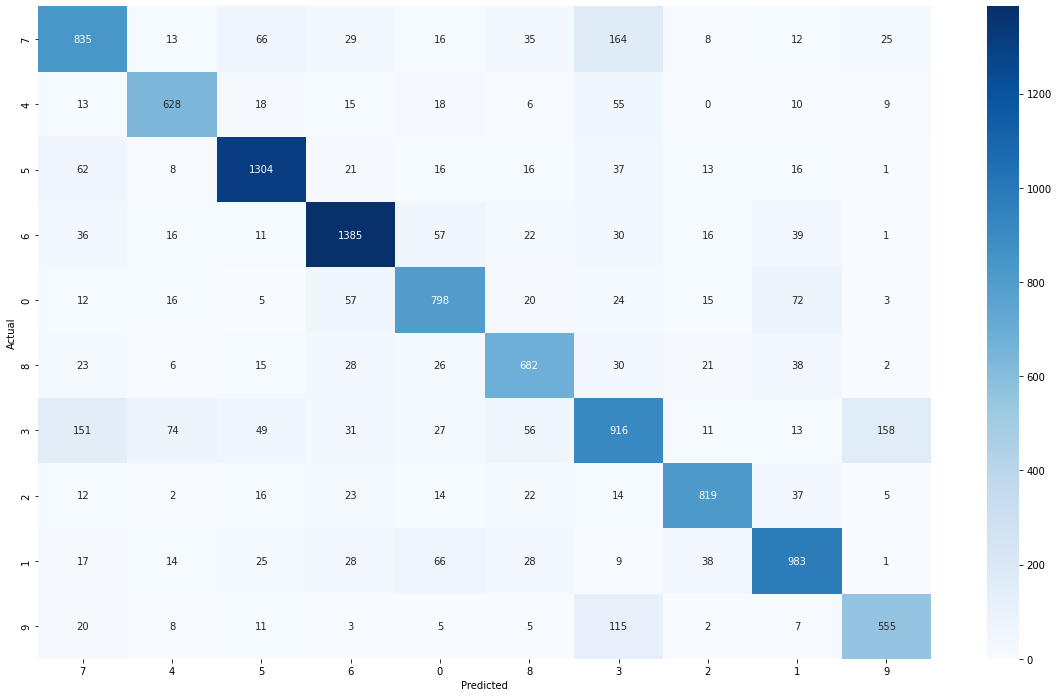

In [29]:
model = train(TransformerCNN(),EPOCH=500,learning_rate=0.08)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch	:0	itr:20	loss:2.29258131980896	acc:0.168

epoch	:0	itr:40	loss:2.2801904678344727	acc:0.212

epoch	:0	itr:60	loss:2.2645070552825928	acc:0.23

epoch	:0	itr:80	loss:2.2187464237213135	acc:0.308

epoch	:1	itr:100	loss:2.150252342224121	acc:0.396

epoch	:1	itr:120	loss:2.086312770843506	acc:0.428

epoch	:1	itr:140	loss:2.0606281757354736	acc:0.428

epoch	:1	itr:160	loss:1.9891602993011475	acc:0.502

epoch	:2	itr:180	loss:1.9828065633773804	acc:0.512

epoch	:2	itr:200	loss:1.9862163066864014	acc:0.482

epoch	:2	itr:220	loss:1.9762365818023682	acc:0.5

epoch	:2	itr:240	loss:1.923837423324585	acc:0.554

epoch	:3	itr:260	loss:1.9257903099060059	acc:0.572

epoch	:3	itr:280	loss:1.931156039237976	acc:0.572

epoch	:3	itr:300	loss:1.929427981376648	acc:0.564

epoch	:3	itr:320	loss:1.8683781623840332	acc:0.608

epoch	:4	itr:340	loss:1.8693127632141113	acc:0.612

epoch	:4	itr:360	loss:1.8835009336471558	acc:0.6

epoch	:4	itr:380	loss:1.88106107711792	acc:0.594

epoch	:4	itr:400	loss:1.833486

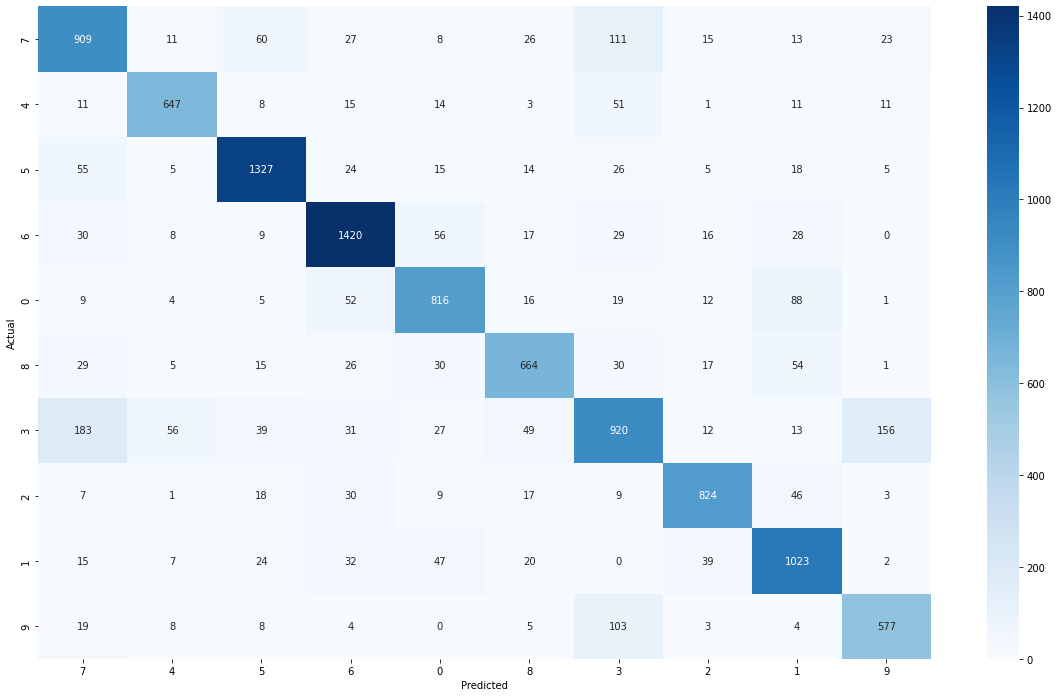

In [33]:
model = train(TransformerRNN(),EPOCH=500,learning_rate=0.08)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

In [ ]:
model = train(SimpleRNN(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

In [ ]:
model = train(SimpleLSTM(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

In [ ]:
model = train(SimpleCNN(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))